# Algorithm prototyping

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import shapely as sh
import shapely.geometry as shg
import shapely.ops as sho
from datetime import datetime

In [2]:
from pyproj import CRS, Transformer

In [3]:
%matplotlib inline

In [4]:
%load_ext autoreload
%autoreload 2

In [25]:
from utils import get_sun_state, project_sunray

## Helper functions

In [6]:
crs_4326 = CRS.from_epsg(4326) # WGS84
crs_25832 = CRS.from_epsg(25832) # ETRS89 / UTM zone 32N
to_wgs_84_transformer = Transformer.from_crs(crs_25832, crs_4326)
to_utm_transformer = Transformer.from_crs(crs_4326, crs_25832)

In [100]:
df = pd.read_csv("data\extracted\dom1l-fp_32349_5660_1_nw.csv")

In [101]:
df = df.sample(100000)

In [102]:
df = gpd.GeoDataFrame(df)

In [103]:
df.head()

,x,y,z,lat,lon
1600226,349195.21,5660117.82,43.65,51.072737,6.847380
2495302,349303.81,5660134.66,43.45,51.072916,6.848922
2591868,349316.16,5660047.95,44.98,51.072141,6.849134
2996689,349368.29,5660043.29,44.66,51.072112,6.849879
3380080,349421.56,5660981.82,39.52,51.080560,6.850248


In [104]:
# creating a geometry column 
geometry = [sh.geometry.Point(xy) for xy in zip(df['lon'], df['lat'])]

# Coordinate reference system : WGS84
crs = {'init': 'epsg:4326'}

In [105]:
# Creating a Geographic data frame 
gdf = gpd.GeoDataFrame(df[["x", "y", "z"]], crs=crs, geometry=geometry)

In [106]:
gdf.head()

,x,y,z,geometry
1600226,349195.21,5660117.82,43.65,POINT (6.847379512541162 51.07273658910175)
2495302,349303.81,5660134.66,43.45,POINT (6.84892150379186 51.0729164400414)
2591868,349316.16,5660047.95,44.98,POINT (6.849133793883347 51.07214050269744)
2996689,349368.29,5660043.29,44.66,POINT (6.849879279466168 51.07211231197208)
3380080,349421.56,5660981.82,39.52,POINT (6.850248145644074 51.08055996602521)


In [107]:
lat_q, lon_q = 51.078534, 6.844748
query_point = shg.Point(lat_q, lon_q)

In [108]:
# filter to 100m around query point first
R = 50
query_point_xy = shg.Point(to_utm_transformer.transform(lon_q, lat_q))
query_region_xy = query_point_xy.buffer(R, resolution=16)
query_region_wgs84 = sho.transform(to_wgs_84_transformer.transform, query_region_xy)

In [109]:
gdf_query = gdf[gdf.intersects(query_region_wgs84)]

In [110]:
len(gdf_query), len(gdf)

(330, 100000)

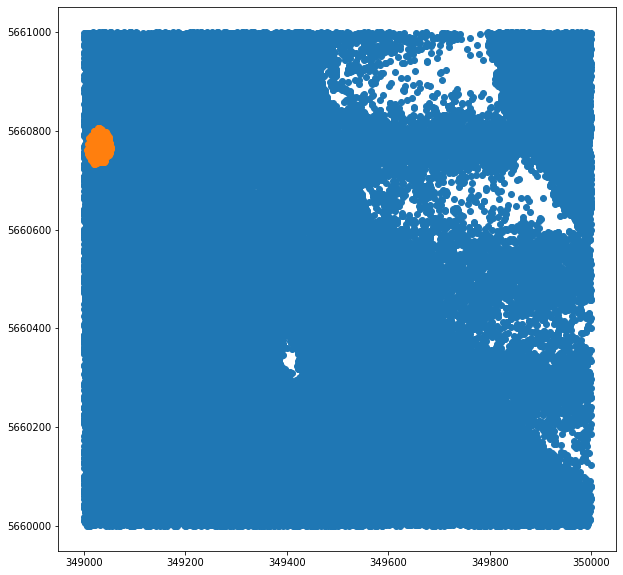

In [111]:
plt.figure(figsize=(10,10))
plt.scatter(gdf["x"], gdf["y"])
plt.scatter(gdf_query["x"], gdf_query["y"])

In [112]:
# get nearest point to the query point
query_nearest_point = gdf_query.loc[gdf_query.distance(sh.geometry.Point(lon_q, lat_q)).idxmin()]

This point is now the origin of the projected axis, so we have to remove the offset of other points

In [113]:
query_nearest_point

x                                               349027
y                                          5.66077e+06
z                                                43.96
geometry    POINT (6.844715155488196 51.0785473324619)
Name: 218721, dtype: object

In [114]:
gdf_query["x_proj"] = gdf_query["x"] - query_nearest_point["x"]
gdf_query["y_proj"] = gdf_query["y"] - query_nearest_point["y"]
gdf_query["z_proj"] = gdf_query["z"] - query_nearest_point["z"]

c:\users\kopyt\.virtualenvs\height-map-jyag_ntc\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
c:\users\kopyt\.virtualenvs\height-map-jyag_ntc\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\kopyt\.virtualenvs\height-map-jyag_ntc\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

In [115]:
gdf_query.head()

,x,y,z,geometry,x_proj,y_proj,z_proj
319753,349040.47,5660741.88,44.01,POINT (6.844911798816762 51.07830372202579),12.98,-27.49,0.05
251094,349031.74,5660736.98,43.93,POINT (6.844789310897938 51.07825739376402),4.25,-32.39,-0.03
213801,349026.83,5660795.96,44.01,POINT (6.844694634081661 51.0787860968225),-0.66,26.59,0.05
203911,349025.53,5660771.65,43.95,POINT (6.844686243374827 51.07856730486521),-1.96,2.28,-0.01
221078,349027.78,5660804.87,43.93,POINT (6.844704464455402 51.0788664121301),0.29,35.50,-0.03


## Sunstate

In [116]:
query_time = datetime(2019, 7, 21, 9, 0, 0)

In [117]:
zen, azimuth = get_sun_state(lat_q, lon_q, query_time)
print(zen, azimuth)

43.55304490574677 119.59839270773891


In [118]:
P = gdf_query[["x_proj", "y_proj", "z_proj"]].values

In [119]:
R = project_sunray(P, zen, azimuth)

In [120]:
# remove all points where z sunray < 0
R = R[R[:, 2] >= 0]

In [121]:
# now we only plot, y and z axis

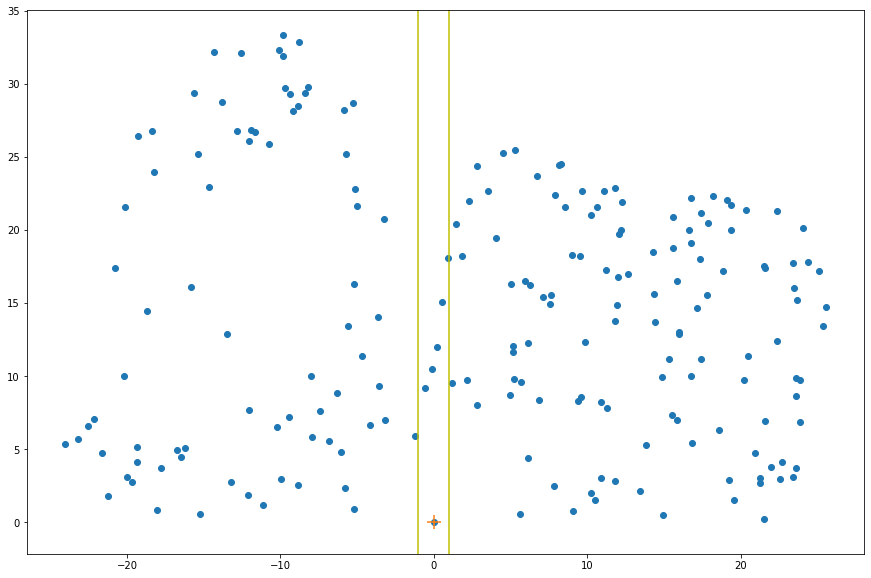

In [122]:
plt.figure(figsize=(15,10))
plt.scatter(R[:, 1], R[:, 2])
plt.scatter(0, 0, s=200, marker="+")
plt.axvline(-1, color="y")
plt.axvline(1, color="y")